In [1]:
!bash -c 'source activate tl-detect && conda install -qy -c conda-forge keras scikit-learn'

Solving environment: ...working... done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda/envs/tl-detect

  added / updated specs: 
    - keras
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    h5py-2.7.1                 |           py35_2         3.9 MB  conda-forge
    keras-2.1.5                |           py35_0         498 KB  conda-forge
    yaml-0.1.7                 |                0         302 KB  conda-forge
    pygpu-0.7.5                |           py35_0         1.4 MB  conda-forge
    mako-1.0.7                 |           py35_0         115 KB  conda-forge
    scipy-1.0.1                |py35_blas_openblas_200        39.4 MB  conda-forge
    markupsafe-1.0             |          

In [29]:
!cat ~/.keras/keras.json

{
    "backend": "tensorflow",
    "image_data_format": "channels_last",
    "epsilon": 1e-07,
    "floatx": "float32"
}

In [246]:
!cp -R ../imgs/training/bosch/Green ../imgs/training/ && cp -R ../imgs/training/bosch/Red ../imgs/training/ && cp -R ../imgs/training/bosch/Yellow ../imgs/training/  && mv ../imgs/training/bosch ../imgs/bosch_tl 

mv: cannot move '../imgs/training/bosch' to '../imgs/bosch_tl/bosch': Directory not empty


In [247]:
! cd ../imgs/training && find . -size 0 -exec rm {} \;

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
# Visualizations will be shown in the notebook.
%matplotlib inline

In [35]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import keras



In [3]:
UNKNOWN = 4
GREEN = 2
YELLOW = 1
RED = 0

In [4]:
import cv2
import os
import numpy as np
import logging
import pandas as pd


In [5]:
import tensorflow as tf

/opt/conda/envs/tl-detect/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [248]:
# dimensions of our images.
img_width, img_height = 38, 20


def read_img(img_path, dim, colspace = 'BGR'):
    if colspace != 'GRAY':
        img = cv2.imread(img_path)
    if img is None:
        raise ValueError('Couldn\'t read img: ' + img_path)
    if colspace == 'HSV':
        logging
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
    return cv2.resize(img, dim, interpolation=cv2.INTER_CUBIC)

def read_color(path, color, dim, colspace):
    x = np.stack([read_img(path + f, dim, colspace) for f in os.listdir(path)], axis=0)
    y = np.full(x.shape[0], color)
    p = np.stack([f for f in os.listdir(path)])
    return (x, y, p)

def read_tl_dir(path, dim, colspace, lib='keras'):
    x = []
    y = []
    p = []
    for directory, color in zip(['Red/', 'Yellow/', 'Green/'], [RED, YELLOW, GREEN]): 
        x_img, y_img, f_path = read_color(os.path.join(path, directory), color, dim, colspace)
        x.append(x_img)
        y.append(y_img)
        p.append(f_path)
    
    x = np.concatenate(x)
    y = np.concatenate(y)
    p = np.concatenate(p)
    x = x.astype('float32')
    x /= 255
    return x, y, p
    

def read_train_test_tl(train_path, test_path, dim, colspace, lib='keras'):
    x_train, y_train, p_train = read_tl_dir(train_path, dim, colspace, lib)
    x_test, y_test, p_test = read_tl_dir(test_path, dim, colspace, lib)

    return x_train, y_train, p_train, x_test, y_test, p_test


train_data_dir = '../imgs/training/'
validation_data_dir = '../imgs/validation/'

x_train, y_train, p_train, x_validation, y_validation, p_validation = read_train_test_tl(train_data_dir, 
                                                                                         validation_data_dir, 
                                                                                         dim=(img_height, img_width),
                                                                                         colspace='HSV', lib='tf')

assert x_train.shape != x_validation.shape
assert x_train.shape[1:] == x_validation.shape[1:]

In [249]:
x = np.concatenate([x_train, x_validation])
y = np.concatenate([y_train, y_validation])
p = np.concatenate([p_train, p_validation])

#### Normalize images

In [154]:
def normalize_img(imgs):
    img_mean = []
    img_std = []
    for ch in range(3):
        img_mean.append(imgs[..., ch].mean())
        img_std.append(imgs[..., ch].std())
    print('mean: {}'.format(img_mean))
    print('std: {} '.format(img_std))
    imgs_corr = np.copy(imgs)
    for ch in range(3):
        imgs_corr[..., ch] = (imgs[..., ch] - img_mean[ch]) / (img_std[ch] + 1e-8)
        
    return imgs_corr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/opt/conda/envs/tl-detect/lib/python3.5/site-packages/matplotlib/cm.py:259: RuntimeWarning: invalid value encountered in multiply
  xx = (xx * 255).astype(np.uint8)


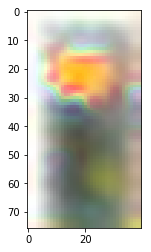

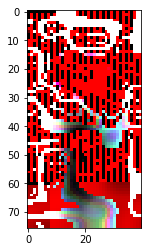

#### Balancedness
Check whether our dataset is balanced

In [10]:
pd.Categorical(y).describe()

,counts,freqs
categories,,
0,2866,0.351053
1,503,0.061612
2,4795,0.587335


4774

In [155]:
import cv2
    

def add_gaussian_noise(X_imgs):
    gaussian_noise_imgs = []
    row, col, _ = X_imgs[0].shape
    # Gaussian distribution parameters
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    
    for X_img in X_imgs:
        gaussian = np.random.random((row, col, 1)).astype(np.float32)
        gaussian = np.concatenate((gaussian, gaussian, gaussian), axis=2)
        gaussian_img = cv2.addWeighted(X_img, 0.75, 0.25 * gaussian, 0.25, 0)
        gaussian_noise_imgs.append(gaussian_img)
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype=np.float32)
    return gaussian_noise_imgs

In [217]:
def translate_imgs(X_imgs):
    translated_imgs = []
    rows, cols, _ = X_imgs[0].shape

    for X_img in X_imgs:
        M = np.float32([[1, 0, np.random.randint(-5,5)], [0, 1, np.random.randint(-5,5)]])
        translated_imgs.append(cv2.warpAffine(X_img, M, (cols, rows)))
    translated_imgs = np.array(translated_imgs, dtype=np.float32)
    return translated_imgs

def rotate_imgs(X_imgs):
    rotated_imgs = []
    rows, cols, _ = X_imgs[0].shape

    for X_img in X_imgs:
        M = cv2.getRotationMatrix2D((cols/2,rows/2), np.random.randint(-15, 15), 1)
        rotated_imgs.append(cv2.warpAffine(X_img, M, (cols, rows)))
    rotated_imgs = np.array(rotated_imgs, dtype=np.float32)
    return rotated_imgs

def flip_imgs(X_imgs):
    flipped_imgs = []
    
    for X_img in X_imgs:
        flipped_imgs.append(cv2.flip(X_img , -1 ))
    flipped_imgs = np.array(flipped_imgs, dtype=np.float32)
    return flipped_imgs
        

In [218]:
def augment_imgs(X_imgs):
    np.random.seed(seed=42)
    col_mod = add_gaussian_noise(X_imgs)
    col_mod = translate_imgs(col_mod)
    col_mod = flip_imgs(col_mod)
    return col_mod

def balance_data(X_imgs, label, target_amount=5000):
    np.random.seed(seed=42)
    x_bal = []
    y_bal = []
    for col in [RED, GREEN, YELLOW]:
        aug_idx = np.random.choice(np.where(label==col)[0], target_amount, replace=True)
        x_bal.append(X_imgs[aug_idx])
        y_bal.append(label[aug_idx])

    x_bal = np.concatenate(x_bal)
    y_bal = np.concatenate(y_bal)
    
    return x_bal, y_bal

2

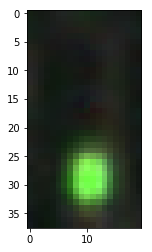

In [245]:
idx =0
plt.imshow(hsv_to_rgb(X_test[idx]))
y_test[idx]

In [259]:
pd.Categorical(y).describe()

,counts,freqs
categories,,
0,1494,0.313536
1,312,0.065477
2,2959,0.620986


col 2


'518406.png0.jpg'

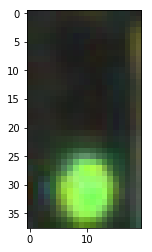

In [262]:
idx = 1497
plt.imshow(hsv_to_rgb(x[idx]))
print('col {}'.format(y[idx]))
p[idx]

In [18]:
x_train.shape[1:]

(76, 40, 3)

In [16]:
batch_size = 1000
epochs = 25

In [40]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_width, img_height)
    x_validation = x_validation.reshape(x_validation.shape[0], 3, img_width, img_height)
    input_shape = (3, img_width, img_heigth)
else:
    x_train = x_train.reshape(x_train.shape[0], img_width, img_height, 3)
    x_validation = x_validation.reshape(x_validation.shape[0], img_width, img_height, 3)
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_validation, y_validation))
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
model.save_weights('first_try.h5')

Train on 7246 samples, validate on 7246 samples
Epoch 1/25
7246/7246 [==============================] - 5s 684us/step - loss: 1.1979 - acc: 0.4510 - val_loss: 0.7744 - val_acc: 0.7755
Epoch 2/25
7246/7246 [==============================] - 4s 616us/step - loss: 0.7130 - acc: 0.7219 - val_loss: 0.6096 - val_acc: 0.7804
Epoch 3/25
7246/7246 [==============================] - 4s 616us/step - loss: 0.6191 - acc: 0.7773 - val_loss: 0.5728 - val_acc: 0.7875
Epoch 4/25
7246/7246 [==============================] - 4s 617us/step - loss: 0.5993 - acc: 0.7811 - val_loss: 0.5893 - val_acc: 0.7833
Epoch 5/25
7246/7246 [==============================] - 4s 616us/step - loss: 0.6021 - acc: 0.7815 - val_loss: 0.5696 - val_acc: 0.7872
Epoch 6/25
7246/7246 [==============================] - 4s 616us/step - loss: 0.5863 - acc: 0.7876 - val_loss: 0.5591 - val_acc: 0.7890
Epoch 7/25
7246/7246 [==============================] - 4s 617us/step - loss: 0.5933 - acc: 0.7861 - val_loss: 0.5569 - val_acc: 0.7893


(15000, 76, 40, 3)

In [271]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

X_train, y_train = balance_data(X_train, y_train)
X_test, y_test = balance_data(X_test, y_test, target_amount=200)
#normalize_img(X_train);
X_train = augment_imgs(X_train)

In [272]:
X_test.shape

(600, 38, 20, 3)

In [275]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

col 0


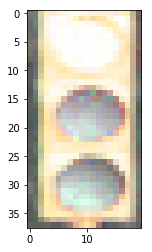

In [302]:
idx = 50
plt.imshow(hsv_to_rgb(X_test[idx]))
print('col {}'.format(y_test[idx]))

In [413]:
from tensorflow.python.estimator.model_fn import ModeKeys as Modes


In [420]:
# Training Parameters
learning_rate = 0.001
batch_size = 128

# Network Parameters
num_input = x.shape[0] 
num_classes = 3 


def create_new_conv_layer(input_data, num_input_channels, num_filters, filter_shape, name):
    # setup the filter input shape for tf.nn.conv_2d
    conv_filt_shape = [filter_shape[0], filter_shape[1], num_input_channels, num_filters]

    # initialise weights and bias for the filter
    weights = tf.Variable(tf.truncated_normal(conv_filt_shape, stddev=0.1), name=name+'_W')
    bias = tf.Variable(tf.truncated_normal([num_filters], stddev=0.1), name=name+'_b')

    # setup the convolutional layer operation
    out_layer = tf.nn.conv2d(input_data, weights, [1, 1, 1, 1], padding='SAME')

    # add the bias
    out_layer += bias
    # apply a ReLU non-linear activation
    out_layer = tf.nn.relu(out_layer)

    return out_layer


def model_fn(features, labels, mode, params):        
    x = features['images']
    input2d = tf.reshape(x, [-1, img_height, img_width, 3])
    input2d = tf.map_fn(lambda img: tf.image.per_image_standardization(img), input2d)

    # create some convolutional layers
    conv1 = tf.layers.conv2d(
        inputs=input2d, 
        filters=32, 
        kernel_size=[5, 5], 
        activation=tf.nn.relu,
        padding='same')
    conv2 = tf.layers.conv2d(
        inputs=conv1, 
        filters=64, 
        kernel_size=[5, 5], 
        activation=tf.nn.relu,
        padding='same')
    conv3 = tf.layers.conv2d(
        inputs=conv2, 
        filters=128, 
        kernel_size=[5, 5], 
        activation=tf.nn.relu,
        padding='same')

    pool1 = tf.nn.max_pool(conv3, 
                           ksize=[1, 2, 2, 1], 
                           strides=[1, 2, 2, 1],
                           padding='SAME',
                           name='pool1')
    conv4 = tf.layers.conv2d(
        inputs=pool1, 
        filters=128, 
        kernel_size=[5, 5], 
        activation=tf.nn.relu,
        padding='same')
    conv5 = tf.layers.conv2d(
        inputs=conv4, 
        filters=128, 
        kernel_size=[5, 5], 
        activation=tf.nn.relu,
        padding='same')

    pool2 = tf.nn.max_pool(conv5, 
                           ksize=[1, 2, 2, 1], 
                           strides=[1, 2, 2, 1],
                           padding='SAME',
                           name='pool2')
    # Apply Dropout (if is_training is False, dropout is not applied)
#        dp1 = tf.layers.dropout(pool2, rate=0.25, training=is_training)

    # Flatten the data to a 1-D vector for the fully connected layer

#        pool2_flat = tf.reshape(pool2, [-1, 5 * 10 * 128])
    fc1 = tf.contrib.layers.flatten(pool2)



    # setup some weights and bias values for this layer, then activate with ReLU
    dense1 = tf.contrib.layers.fully_connected(inputs=fc1, num_outputs=1024, activation_fn=tf.nn.relu)
    dense2 = tf.contrib.layers.fully_connected(inputs=dense1, num_outputs=128, activation_fn=tf.nn.relu)
    logits = tf.contrib.layers.fully_connected(inputs=dense2, num_outputs=3)

    # Define operations
    if mode in (Modes.PREDICT, Modes.EVAL):
        predicted_indices = tf.argmax(input=logits, axis=1)
        probabilities = tf.nn.softmax(logits, name='softmax_tensor')
        
    if mode in (Modes.TRAIN, Modes.EVAL):
        global_step = tf.train.get_or_create_global_step()
        print(labels)
        label_indices = tf.cast(labels, tf.int32)
        loss = tf.losses.softmax_cross_entropy(
            onehot_labels=tf.one_hot(label_indices, depth=3), logits=logits)
        tf.summary.scalar('OptimizeLoss', loss)
    
    if mode == Modes.PREDICT:
        predictions = {
            'classes': predicted_indices,
            'probabilities': probabilities
        }
        export_outputs = {
            SIGNATURE_NAME: tf.estimator.export.PredictOutput(predictions)
        }
        return tf.estimator.EstimatorSpec(
            mode, predictions=predictions, export_outputs=export_outputs)

    if mode == Modes.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss, global_step=global_step)
        return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

    if mode == Modes.EVAL:
        eval_metric_ops = {
            'accuracy': tf.metrics.accuracy(label_indices, predicted_indices)
        }
        return tf.estimator.EstimatorSpec(
            mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [421]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_is_chief': True, '_num_worker_replicas': 1, '_save_summary_steps': 100, '_task_type': 'worker', '_session_config': None, '_num_ps_replicas': 0, '_log_step_count_steps': 100, '_master': '', '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None, '_service': None, '_global_id_in_cluster': 0, '_task_id': 0, '_evaluation_master': '', '_save_checkpoints_secs': 600, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd4d9ba5e80>, '_keep_checkpoint_max': 5, '_model_dir': '/tmp/tmpyhul1oos', '_tf_random_seed': None}


In [424]:
np.random.seed(seed=42)
tf.set_random_seed(seed=42)

# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    {'images': X_train}, y=y_train,
    batch_size=batch_size, num_epochs=10, shuffle=True)
# Train the Model
model.train(input_fn)

# Define the test inputs
test_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={'images': X_test}, y=y_test,
      num_epochs=1,
      shuffle=False)
# Test the Model
model.evaluate(test_input_fn)

INFO:tensorflow:Calling model_fn.
Tensor("random_shuffle_queue_DequeueUpTo:2", shape=(?,), dtype=int64, device=/device:CPU:0)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpyhul1oos/model.ckpt-1
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2 into /tmp/tmpyhul1oos/model.ckpt.
INFO:tensorflow:loss = 1.349135, step = 2
INFO:tensorflow:global_step/sec: 33.4614
INFO:tensorflow:loss = 1.0986123, step = 102 (2.991 sec)
INFO:tensorflow:global_step/sec: 34.4705
INFO:tensorflow:loss = 1.0986123, step = 202 (2.899 sec)
INFO:tensorflow:global_step/sec: 34.4137
INFO:tensorflow:loss = 1.0986123, step = 302 (2.906 sec)
INFO:tensorflow:global_step/sec: 34.3107
INFO:tensorflow:loss = 1.0986123, step = 402 (2.915 sec)
INFO:tensorflow:global_step/sec: 34.0421
INFO:tensorflow:loss = 1.0986123, step = 502 (2.9

{'accuracy': 0.33333334, 'global_step': 1173, 'loss': 1.0986123}

In [423]:
def serving_input_receiver_fn():
    """Build the serving inputs."""
    # The outer dimension (None) allows us to batch up inputs for
    # efficiency. However, it also means that if we want a prediction
    # for a single instance, we'll need to wrap it in an outer list.
    inputs = {'images': tf.placeholder(shape=[None, img_height, img_width, 3], dtype=tf.float32)}
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

export_dir = model.export_savedmodel(export_dir_base='.', serving_input_receiver_fn=serving_input_receiver_fn)

INFO:tensorflow:Calling model_fn.


NameError: name 'SIGNATURE_NAME' is not defined